In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### Load the data

In [13]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z.fits') # galaxies data
#samples = Table.read('../fits/SF_fits/samples.fits') # galaxy samples data
sparcfire_samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')
mendel_masses = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
g_ok = Table.read('g_vs_r/g_ok.fits')

In [5]:
sparcfire_g = Table.read('../sparcfire_directories/g/g.galaxy_matched.fits') # sparcfire data
sparcfire_r = Table.read('../sparcfire_directories/r/r.galaxy_matched.fits') # sparcfire data

In [6]:
import pandas as pd
sparcfire_g_arcs = pd.read_csv('../sparcfire_directories/g/g.galaxy_arcs.csv') # individual arc data
sparcfire_r_arcs = pd.read_csv('../sparcfire_directories/r/r.galaxy_arcs.csv') # individual arc data

#### Now create our samples, using masks

In [22]:
# Look for spirals (Hart+17 method), which have been successfully reduced in sparcfire
g_fit_ok = np.all([sparcfire_g['fit_state'] == 'OK',g_ok['ok']],
                  axis=0)
r_fit_ok = sparcfire_r['fit_state'] == 'OK'

spiral_ok = np.all([sparcfire_samples[c] for c in ['in_mass_limit','axial_ok','in_spiral']],
                   axis=0)

spiral_sample = np.all([g_fit_ok,r_fit_ok,spiral_ok],axis=0)
print('{} galaxies OK in the g+r bands'.format(spiral_sample.sum()))

# Convert sparcfire chiralitites to binary values (for fast lookup)
id_column = np.array(sparcfire_g['dr8objid']).astype(np.int64)
chi_g_column = np.array(sparcfire_g['chirality_wtdPangSum'] == 'S-wise').astype(np.int)
chi_r_column = np.array(sparcfire_r['chirality_wtdPangSum'] == 'Swise').astype(int)
chi_g_array = np.array([id_column,chi_g_column]).T
chi_r_array = np.array([id_column,chi_r_column]).T

2671 galaxies OK in the g+r bands


In [20]:
def measure_weighted_average(data,columns):
    p_array = np.array([data[c] for c in columns]).T
    p_array[np.isfinite(p_array) == False] = 0
    p_mean = np.zeros(len(p_array))
    p_sum = np.sum(p_array,axis=1)
    for c in range(len(columns)):
        p_mean += (c+1)*p_array[:,c]
    p_mean = p_mean/p_sum
    p_mean[np.isfinite(p_mean) == False] = 0
    p_absolute = np.argmax(p_array,axis=1) + 1
    return p_mean, p_absolute

m_columns = ['t11_arms_number_a31_1_debiased_rh',
             't11_arms_number_a32_2_debiased_rh',
             't11_arms_number_a33_3_debiased_rh',
             't11_arms_number_a34_4_debiased_rh',
             't11_arms_number_a36_more_than_4_debiased_rh']

w_columns =  ['t10_arms_winding_a28_tight_debiased_rh',
              't10_arms_winding_a29_medium_debiased_rh',
              't10_arms_winding_a30_loose_debiased_rh']

m_wtd_average, m_absolute = measure_weighted_average(gz2_data,m_columns)
w_wtd_average, w_absolute = measure_weighted_average(gz2_data,w_columns)
gz_statistics = Table(np.array([m_wtd_average,m_absolute,w_wtd_average,w_absolute]).T,
                      names=('m_wtd_avg','m','w_wtd_avg','w'),
                      dtype=(float,int,float,int))

spiral_statistics = gz_statistics[spiral_sample]

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


#### In bins of $m_\mathrm{wtd \, avg}$, at what length should we cut the data?
1. Using a _single_ length cut?
2. Investigate a _variable_ length cut?
3. Compare pitch angles?

#### Considerations:
- log space (ie. effectively 'downweighting' the top end)
- $N$ or $N_\mathrm{wtd \, avg}$

In [24]:
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit
from lookup_arcs import ArcLookup, ArcStats # my class for measuring arc statistics
from xy_plots import x_vs_y # my class for binning and plotting
from bin_statistics import assign_bins # my binning class

colors = 'bgyrmk'

#### To at least test whether a fit to the data is reasonable, we will do the most basic possible fit (linear)

---> This should _at least_ be able to fit the data slightly better, ie. go the right way

### Now do the same for a series of fixed cuts
- This is essentially what we plot in the 4 panel plots with 4 colours above, but for a more continuous range.

In [29]:
# Here, we'll get all of the individual arc data into rows to map onto gz_data

ids = sparcfire_g['dr8objid'][spiral_sample]

arc_table_g = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),
                  dtype=(int,int,object,object,object,object,object))
arc_table_r = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),
                  dtype=(int,int,object,object,object,object,object))

for id_ in ids:
    a = ArcLookup(id_)
    chi_g = a.chirality(chi_g_array)
    arc_list = a.arc_list(sparcfire_g_arcs,chi_g)
    arc_table_g.add_row(arc_list)
    
for id_ in ids:
    a = ArcLookup(id_)
    chi_r = a.chirality(chi_r_array)
    arc_list = a.arc_list(sparcfire_r_arcs,chi_r)
    arc_table_r.add_row(arc_list)
    
arc_table_all_g = Table(np.zeros((len(gz2_data),7)),
                        names=('id','N','P','L','intensity','N_pixels','L_f'),
                        dtype=(int,int,object,object,object,object,object))
arc_table_all_g[spiral_sample] = arc_table_g

arc_table_all_r = Table(np.zeros((len(gz2_data),7)),
                        names=('id','N','P','L','intensity','N_pixels','L_f'),
                        dtype=(int,int,object,object,object,object,object))
arc_table_all_r[spiral_sample] = arc_table_r

In [32]:
# Here, we are simply going over a range of possible L cuts (20-100) and find the best agreement in each case

def measure_chi(x,y,logged=False,log=False):
    if (logged is False) and (log is True):
        x, y = np.log10(x), np.log10(y)    
    elif (logged is True) and (log is False):
        x, y = 10**(x), 10**(y)
    ok = ((np.all([np.isfinite(x),np.isfinite(y)],axis=0) if log is True 
          else np.all([x>0,y>0],axis=0)))
    
    absolute_chi = np.absolute(x[ok]-y[ok])
    chi_mean = np.mean(absolute_chi)
    return chi_mean


def find_best_px(x,function,pxs=np.linspace(20,100,81),log=False,
                 return_values=False):
    chi_array = np.empty(pxs.size)
    for p, px in enumerate(pxs):
        y = function(px)
        chi = measure_chi(x,y,log=log)
        chi_array[p] = chi
    best_index = chi_array.argmin()
    best_px = pxs[best_index]
    if return_values is True:
        return pxs, chi_array
    else:
        return best_px
    
x = spiral_statistics['m_wtd_avg']
px_r, chi_r = find_best_px(x,ArcStats(arc_table_r).N_weighted_average,return_values=True)
px_g, chi_g = find_best_px(x,ArcStats(arc_table_g).N_weighted_average,return_values=True)
#px_absolute = find_best_px(x,ArcStats(arc_table).N_weighted_average)

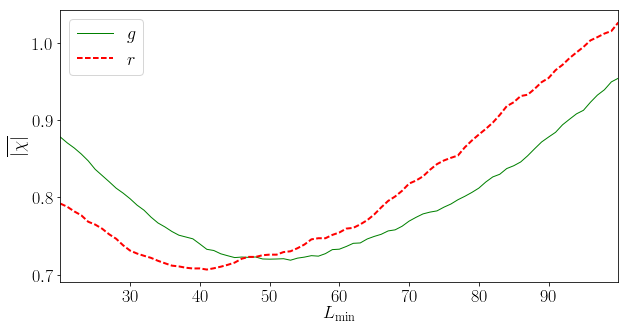

In [38]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim(20,100)

_ = plt.plot(px_g,chi_g,color='g',lw=1,label='$g$')
_ = plt.plot(px_r,chi_r,color='r',lw=2,linestyle='dashed',label='$r$')
#_ = plt.axvline(px_absolute,color='k',lw=1,linestyle='dashed')
ax.set_xlabel('$L_\mathrm{min}$')
ax.set_ylabel('$\overline{|\chi|}$')
ax.legend()
#fig.savefig('figures/measure_best_chi.pdf')

#print(chi.min())